# Pruebas para hacer CV utilizando conjuntos de entrenamiento, validación y test

Consideraré 5 particiones training-validación-test en tamaños:
- Train: 70
- Validación: 10
- Test: 20
El número óptimo de epochs se determina al detectar que en 3 epochs sucesivas no mejora
el rendimiento sobre el conjunto de validación.

Se tomaría como número de epochs el que da rendimiento más alto.
Después se entrena con todo el training (incluido el corpus de validación) usando ese número de epochs y se evalúa el rendimiento sobre el conjunto de test.
- Train: 80
- Test: 20

Se hace lo mismo con cada una de las 5 particiones.

**CAMBIO**: *Hemos decidido que para agilizar el proceso, en los modelos que no nos interesen particularmente, será suficiente hacer únicamente el primer paso en 70-10-20, y quedarnos con la puntuación sobre el conjunto de test, aunque el modelo esté entrenado solo al 70%*.

In [1]:
import sys, os, time, functools
sys.path.append('/home/jovyan/work/databases/HASY/')
os.makedirs("./models_cv/", exist_ok=True)
os.makedirs("./plots_cv/", exist_ok=True)

from hasy_tools_updated import *

import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import sklearn.metrics as metrics

start_time = time.time()

2024-03-26 19:20:45.293032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 19:20:45.549908: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay


In [18]:
fold = 1

X_train, y_train, symbol_id2index_train, index2symbol_id_train = load_database(f'/home/jovyan/work/databases/HASY/benat-data/cv/fold-{fold}/train.csv')
X_test, y_test, symbol_id2index_test, index2symbol_id_test = load_database(f'/home/jovyan/work/databases/HASY/benat-data/cv/fold-{fold}/test.csv')
print(f"Fold {fold} loaded----------------------------------------")

# First, get the ID of each label:
y_train_id = np.array([index2symbol_id_train[element] for element in y_train])
y_test_id = np.array([index2symbol_id_test[element] for element in y_test])
print("Converted y indexes to symbol IDs")
# Go back to indexes, but use the SAME indexing SYSTEM for all:
y_train = np.array([symbol_id2index_train[element] for element in y_train_id])
y_test = np.array([symbol_id2index_train[element] for element in y_test_id])    
print("Converted y symbol IDs to same index system")

# Data scaling
X_train, X_test = X_train / 255., X_test/ 255.
y_train, y_test = y_train.astype(int), y_test.astype(int)
print("Data scaled", end='\n\n')

# Reshape the data to 2D:
X_train = X_train.reshape(X_train.shape[0],32,32)[..., np.newaxis]
X_test = X_test.reshape(X_test.shape[0],32,32)[..., np.newaxis]
# Another option: tf.image.resize(images, [32,32])

Fold 1 loaded----------------------------------------
Converted y indexes to symbol IDs
Converted y symbol IDs to same index system
Data scaled



In [7]:
# Split the training data in train0 and validation0

# Split in 70-10, this is:
print(len(y_train)*70/80) # 94209.5
print(len(y_train)*10/80) # 13458.5
print(len(y_train)) # 107668

94209.5
13458.5
107668


In [19]:
index_split = int(len(y_train)*70/80)

X_train0 = X_train[:index_split]
X_val0 = X_train[index_split:]

y_train0 = y_train[:index_split]
y_val0 = y_train[index_split:]

In [39]:
# Reset keras session:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# MODEL: 2-LAYER
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2)), # Default values.
    keras.layers.Flatten(),
    keras.layers.Dense(369, activation="softmax")
])

# Model summary:
model.build(X_train.shape) 
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (107668, 32, 32, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (107668, 16, 16, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (107668, 8192)            0         
                                                                 
 dense (Dense)               (107668, 369)             3023217   
                                                                 
Total params: 3,023,537
Trainable params: 3,023,537
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])    

# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,  monitor="val_accuracy", mode = "max", restore_best_weights=False) #IMPORTANT: Patience = 3.
checkpoint = tf.keras.callbacks.ModelCheckpoint(f"./models_cv/best_model_fold_{fold}.h5", 
                monitor="val_accuracy", mode="max", save_weights_only = False, save_best_only=True, verbose=1)


In [41]:
history = model.fit(X_train0, y_train0, epochs=20, callbacks=[early_stopping_cb, checkpoint],
                    verbose=2, 
                    validation_data=(X_val0, y_val0)) # Validation data is provided!

print("The model has been trained.")

Epoch 1/20
2945/2945 [==============================] - 198s 67ms/step - loss: 1.6013 - accuracy: 0.6397 - val_loss: 1.1331 - val_accuracy: 0.7201
Epoch 2/20
2945/2945 [==============================] - 204s 69ms/step - loss: 0.7487 - accuracy: 0.7940 - val_loss: 1.0644 - val_accuracy: 0.7281
Epoch 3/20
2945/2945 [==============================] - 200s 68ms/step - loss: 0.4487 - accuracy: 0.8665 - val_loss: 1.1429 - val_accuracy: 0.7351
Epoch 4/20
2945/2945 [==============================] - 204s 69ms/step - loss: 0.2634 - accuracy: 0.9169 - val_loss: 1.2619 - val_accuracy: 0.7296
Epoch 5/20
2945/2945 [==============================] - 204s 69ms/step - loss: 0.1621 - accuracy: 0.9468 - val_loss: 1.4381 - val_accuracy: 0.7249
Epoch 6/20
2945/2945 [==============================] - 218s 74ms/step - loss: 0.1098 - accuracy: 0.9630 - val_loss: 1.6038 - val_accuracy: 0.7295
The model has been trained.


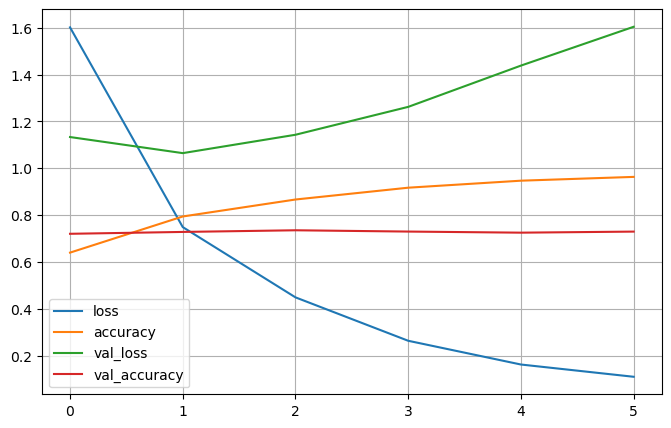

In [42]:
#Save history
df = pd.DataFrame(history.history)
df.to_csv(f'./models_cv/history_fold_{fold}_pruebas2.csv')

# Plot
df.plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.savefig(f"./plots_cv/learning_curves_plot_fold_{fold}_pruebas2.png", dpi=200)

In [43]:
# Best epoch number:
n_epochs_best = np.argmax(history.history['val_accuracy'])
print(n_epochs_best)

2


In [44]:
y_proba = model.predict(X_test)
y_pred = np.argmax(y_proba, axis=-1)

842/842 [==============================] - 6s 7ms/step


In [45]:
metrics.accuracy_score(y_test, y_pred)

0.733895534586522